## Play with the analytical Bayes solution

**Goal:** In this notebook you will use the analytical Bayes solution to investigate the effect of the prior and and the number of training examples on the posterior distributions.

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.

**Dataset:** Artificial Data

**Content:** 

* Analytical Solution for real priors (weights and predictive distribution)
* Simulation Study: Effect of prior and training data size
* Simulation Study: NLL versus number of training examples

In [26]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [27]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  False


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(1)
tf.random.set_seed(1)

TFP Version 0.8.0
TF  Version 2.0.0


### Definition of the analytical Solution 

We repeat the code for the analytical solution here. See also bottom of [nb_ch_07_02](https://github.com/tensorchiefs/dl_book/blob/master/chapter_07/nb_ch07_02.ipynb) for more details and comparision.

In [29]:
def make_design_matrix(x):
    return np.hstack((np.ones((len(x),1)), x))

def posterior(x, y, one_over_var0, var):
    """
        x vector with training x data
        y vector with training y values
        one_over_var0 1/𝜎0^2 the variances of the prior distribution
        var is the assumed to be known variance of data
        @returns mean vector mu and covariance Matrix Sig 
    """
    X = make_design_matrix(x)
    Sig_inv = one_over_var0 * np.eye(X.shape[1]) + X.T.dot(X) / var
    Sig = np.linalg.inv(Sig_inv)
    mu = Sig.dot(X.T).dot(y) / var
    return mu, Sig

def posterior_predictive(x_test, mu, Sig, var):
    """
        x_test the positions, where the posterior is to be evaluated
        mu the mean values of the weight-posterior
        Sig the covariance matrix 
        var is the assumed to be known variance of data 
        Computes mean and variances of the posterior predictive distribution of y
    """
    X_test = make_design_matrix(x_test)
    y = X_test.dot(mu)
    # Only compute variances (diagonal elements of covariance matrix)
    y_var = var + np.sum(X_test.dot(Sig) * X_test, axis=1)  
    return y, y_var

## Example from the Bayes the Hacker's way

We createt the same data points as we had in the nb_ch_07_02

In [39]:
xmin = -5;xmax = +5;ymin=-40;ymax=40;sigma=3
save = True
np.random.seed(2)
num = 4
x = np.linspace(-2,2,num=num).reshape((num,1))
y = 2 * x[:,0] - 1 + 1.*np.random.normal(0,sigma,num) 

### Infinitly large priors

We first have a look at the infinite large prior, this is the same solution as used the Bayes the Hackers way.

Coefficients: 
 [2.92051026]
Coefficients: 
 -1.726712471421449


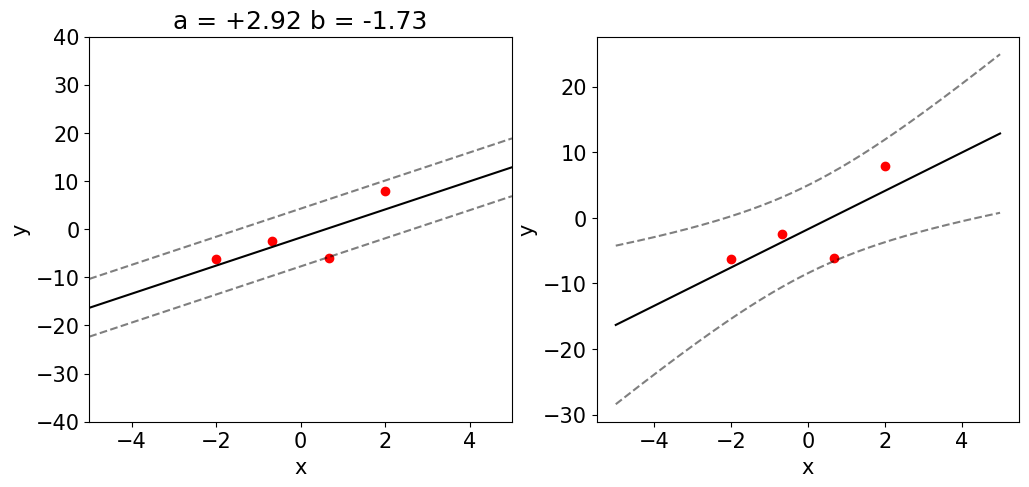

In [41]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x,y)
# The coefficients
a_ml = regr.coef_
b_ml = regr.intercept_
print('Coefficients: \n', a_ml)
print('Coefficients: \n', b_ml)
a = a_ml[0]
b = b_ml

plt.figure(figsize=(12,5))
plt.style.use('default') # macht den hintergrund weg 
plt.rcParams.update({'font.size': 15}) #Macht grosse axen

plt.subplot(1,2,1)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.plot([xmin, xmax], [a*xmin+b, a*xmax+b], color='black')
plt.plot([xmin, xmax], [a*xmin+b+2*sigma, a*xmax+b+2*sigma], linestyle='dashed', alpha=0.5,color='black')
plt.plot([xmin, xmax], [a*xmin+b-2*sigma, a*xmax+b-2*sigma], linestyle='dashed', alpha=0.5,color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x,y, marker='o', color='r')
plt.title('a = {:+.2f} b = {:+.2f}'.format(a,b))  

########
# Bayes

plt.subplot(1,2,2)
xs = np.linspace(xmin,xmax,250).reshape((250,1))
m, Sigma = posterior(x, y, 0, sigma**2) #1/sigma_0**2 = 0 ==> Bayes with infinitely large prior Bayes the hacker's way.
y_mu, yt_var = posterior_predictive(xs, m, Sigma, sigma**2)
y_mu[0], yt_var[0] 
ax = plt.gca()
plt.plot(xs, y_mu, color = 'black')
plt.plot(xs, y_mu + 2 * np.sqrt(yt_var),linestyle='dashed', alpha=0.5,color='black')
plt.plot(xs, y_mu - 2 * np.sqrt(yt_var),linestyle='dashed', alpha=0.5,color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x,y,color='r')

plt.savefig('ch07_bm.pdf') 

### Real priors $(a,b) \sim N(0,1)$

To get a first feeling, how the data effects the prior, we evaluate the prior and the posterior for the four data points from above. The prior for two variables a and b is a multivariare normal. We use the TFP implementation for that.    

In [35]:
norm = tfd.MultivariateNormalDiag(loc=(0,0), scale_diag=(1,1))
norm.prob((1.0,2.0))

<tf.Tensor: id=942528, shape=(), dtype=float32, numpy=0.013064231>

#### Prior and Posterior of the weights

In the following, we plot the prior and the posterior. The posterior is obtained from the analytical solution. 

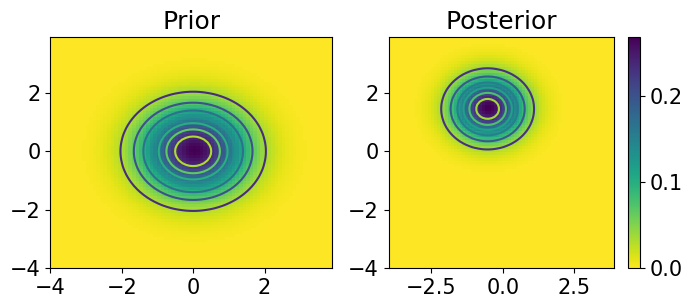

In [46]:
plt.figure(figsize=(8,3))

ai=np.arange(-4, 4, 0.1)
bi=np.arange(-4, 4, 0.1)

X, Y = np.meshgrid(ai, bi)

#### Prior
norm = tfd.MultivariateNormalDiag(loc=(0,0), scale_diag=(1,1))
def f(a,b):
    return norm.prob((a,b)).numpy()

zs = np.array([f(a,b) for a,b in zip(np.ravel(X), np.ravel(Y))])
zs=zs.reshape(X.shape)
cmap = plt.get_cmap('viridis_r',)
plt.subplot(1,2,1)
plt.pcolormesh(ai, bi, zs, cmap=cmap)
plt.contour(ai, bi, zs)
plt.title('Prior')

#### Posterior
m, Sigma = posterior(x, y, 1/sigma_0**2, sigma**2)
norm = tfd.MultivariateNormalFullCovariance(loc=m, covariance_matrix=Sigma)
def f(a,b):
    return norm.prob((a,b)).numpy()

zs = np.array([f(a,b) for a,b in zip(np.ravel(X), np.ravel(Y))])
zs=zs.reshape(X.shape)

plt.subplot(1,2,2)
plt.title('Posterior')
plt.pcolormesh(ai, bi, zs, cmap=cmap)
plt.colorbar()
plt.contour(ai, bi, zs)#,[scipy.stats.norm(0, sigma).pdf(2*sigma)])

As you can see the data "moves" the posterior from the prior. 

#### Predictive Distribution

We see the same behavoir in the predictive distribution. The prior predictive distribution is moved to the data.

(-25, 25)

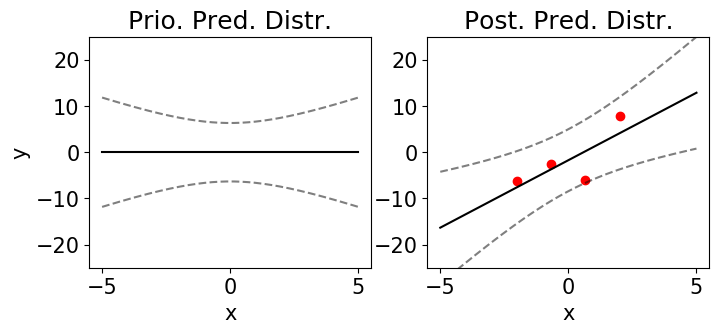

In [54]:
plt.figure(figsize=(8,3))
m=(0,0)
Sigma = [[1,0],[0,1]]
y_mu, yt_var = posterior_predictive(xs, m, Sigma, sigma**2)

plt.subplot(1,2,1)
plt.plot(xs, y_mu, color = 'black')
plt.plot(xs, y_mu + 2 * np.sqrt(yt_var),linestyle='dashed', alpha=0.5,color='black')
plt.plot(xs, y_mu - 2 * np.sqrt(yt_var),linestyle='dashed', alpha=0.5,color='black')
plt.ylim(-25,25)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Prio. Pred. Distr.')

plt.subplot(1,2,2)
m, Sigma = posterior(x, y, 0.0, sigma**2)
y_mu, yt_var = posterior_predictive(xs, m, Sigma, sigma**2)
y_mu[0], yt_var[0] 

plt.plot(xs, y_mu, color = 'black')
plt.plot(xs, y_mu + 2 * np.sqrt(yt_var),linestyle='dashed', alpha=0.5,color='black')
plt.plot(xs, y_mu - 2 * np.sqrt(yt_var),linestyle='dashed', alpha=0.5,color='black')
plt.title('Post. Pred. Distr.')
plt.xlabel('x')
plt.scatter(x,y,color='r')
plt.ylim(-25,25)

No, let's start with the simulation study and invesitage the effect on the predicton performance.

## Simulation Study 

To show that the Bayesian Treatment has also a positive effect on the prediction preformance in the interpolation case. Because, we want to study the effect with varying data size, you need to define a function which can create training data.  

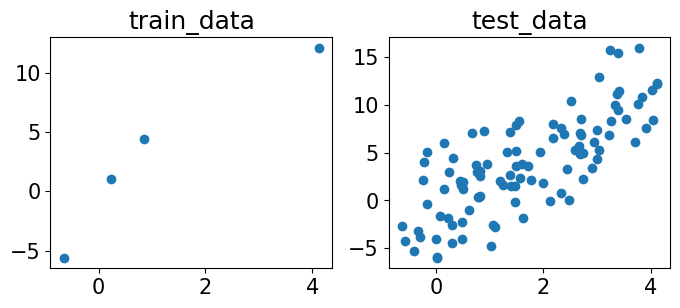

In [57]:
plt.figure(figsize=(8,3))
def get_data(N_train, N_test,sigma):
    x=np.random.uniform(-5,5,size=N_train)
    noise=np.random.normal(loc=0,scale=sigma,size=N_train)# const var
    y=2.7*x+noise #y linear model with const var
    y_train=y.reshape((len(y),1))
    x_train=x.reshape((len(x),1))
    x_test=np.random.uniform(min(x_train),max(x_train),size=N_test)
    noise=np.random.normal(loc=0,scale=sigma,size=N_test)# const var
    y_test=2.7*x_test+noise #y linear model with const var
    y_test=y_test.reshape((len(y_test),1))
    x_test=x_test.reshape((len(x_test),1))
    return x_train, y_train, x_test, y_test
  
N_train = 4
N_test  = 100
sigma = 3
x_train, y_train, x_test, y_test = get_data(N_train, N_test,sigma)
plt.subplot(1,2,1)
plt.scatter(x_train, y_train)
plt.title("train_data")
plt.subplot(1,2,2)
plt.scatter(x_test, y_test)
plt.title("test_data")
plt.show()

Posterior predictive distribution.

[10.6919668] 9.375164374795371


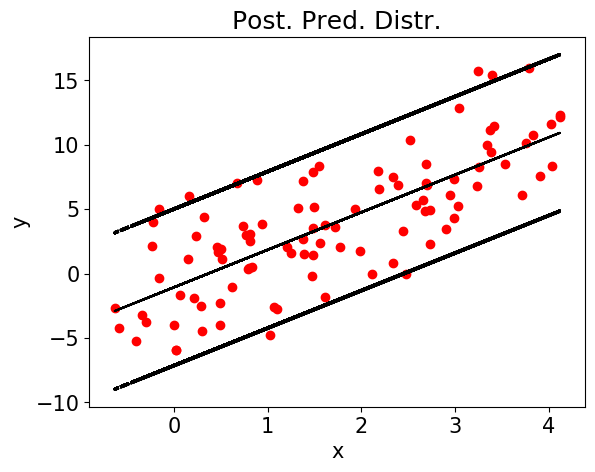

In [59]:
m, Sigma = posterior(x_test, y_test, 0.0, sigma**2)
y_mu, yt_var = posterior_predictive(x_test, m, Sigma, sigma**2)
print(y_mu[0], yt_var[0])

plt.plot(x_test, y_mu, color = 'black')
plt.plot(x_test, y_mu + 2 * np.sqrt(yt_var),linestyle='dashed', alpha=0.5,color='black')
plt.plot(x_test, y_mu - 2 * np.sqrt(yt_var),linestyle='dashed', alpha=0.5,color='black')
plt.title('Post. Pred. Distr.')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x_test,y_test,color='r')

## Investigating the effect of the prior and training data set

How does the predictive distribution depend on the prior and the amount of training data?

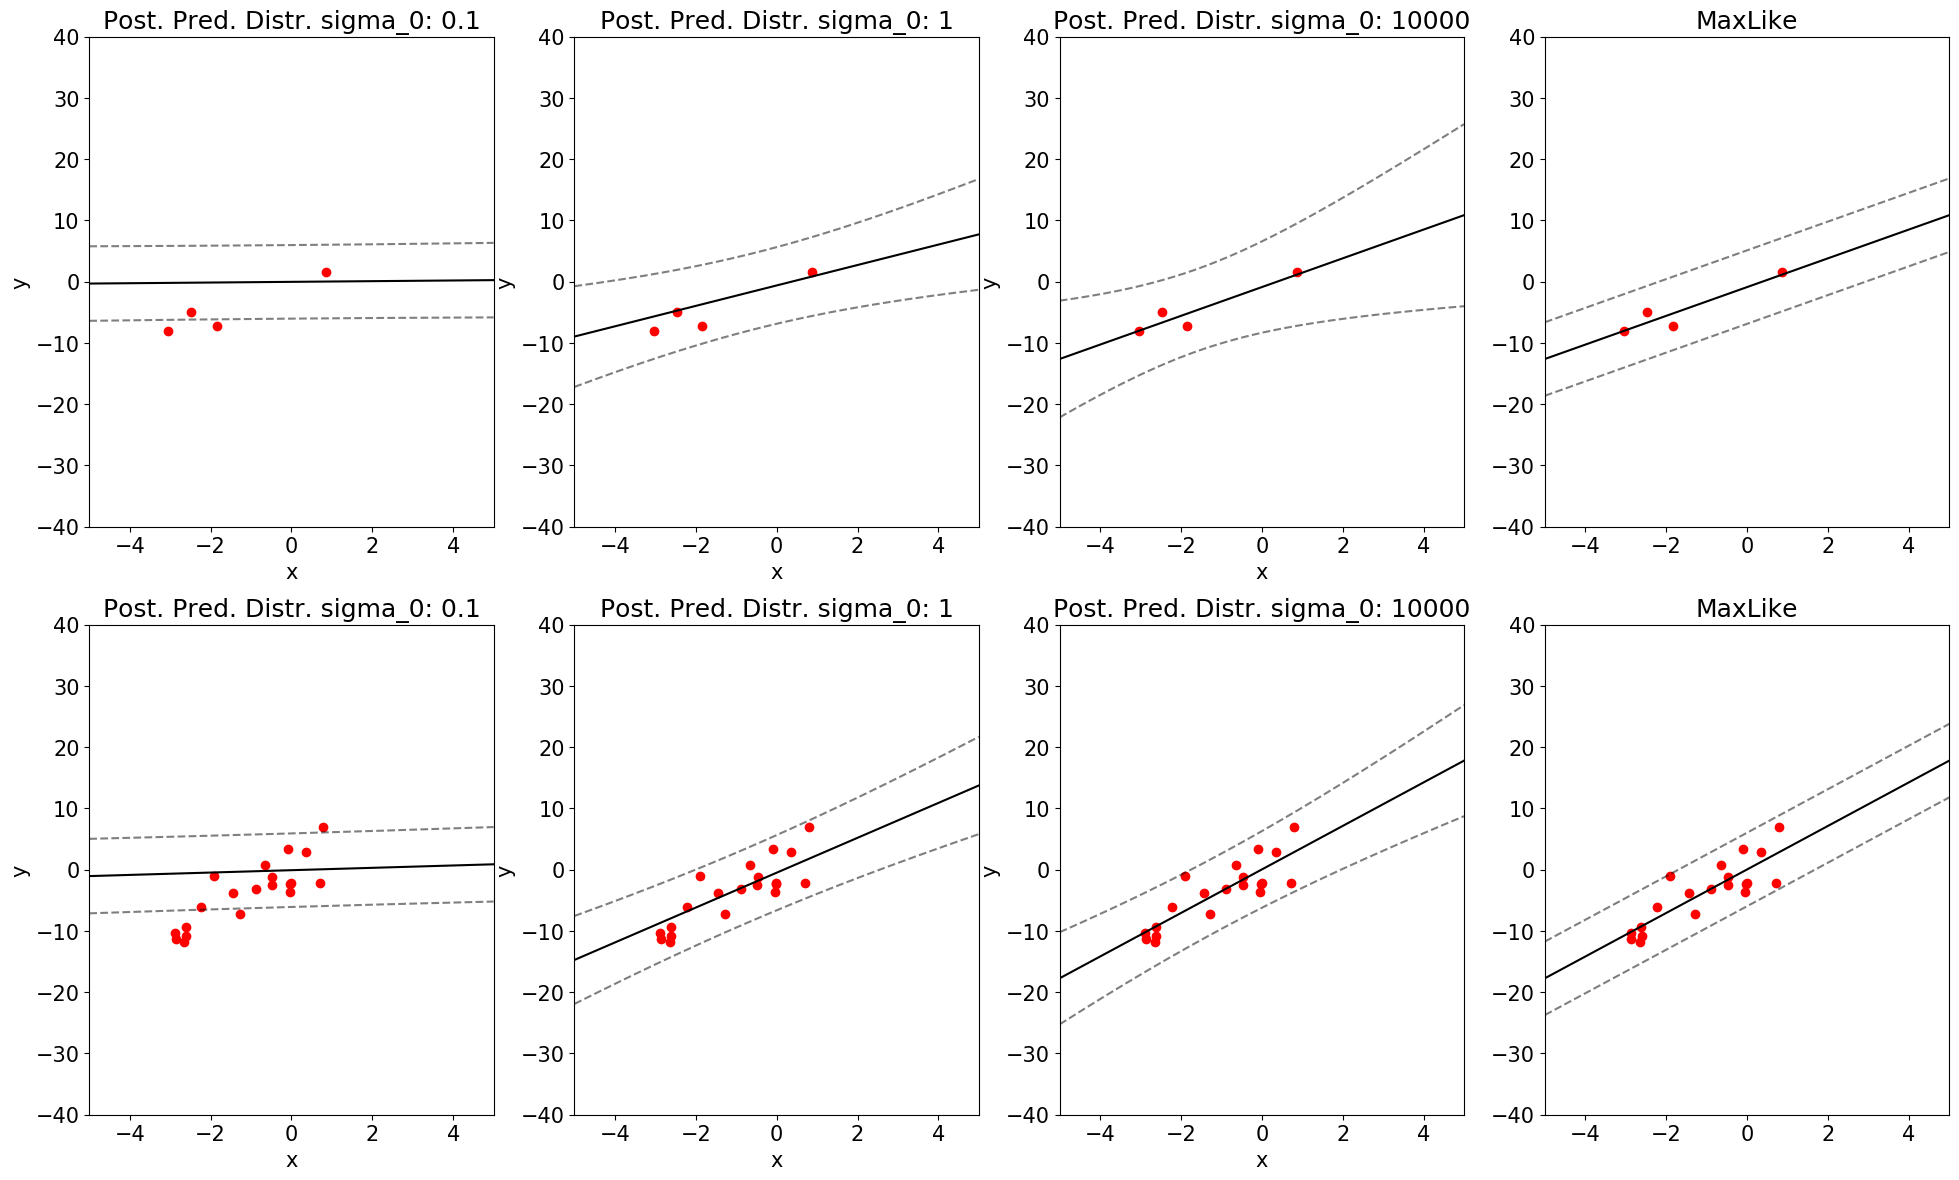

In [70]:
np.random.seed(1251)
x_train1, y_train1, x_train2, y_train2=get_data(4,20,sigma=sigma)
#### plot from book
#x, y, _, _ = get_data(N_train=20, N_test=42,sigma=sigma)


plt.figure(figsize=(24,14))

# new
plt.subplot(2,4,1)
sigma_0=0.1
m, Sigma = posterior(x_train1, y_train1, 1./sigma_0**2, sigma**2)
y_mu, yt_var = posterior_predictive(xs, m, Sigma, sigma**2)
#print(y_mu[0], yt_var[0]) 
y_mu=y_mu.flatten()

plt.plot(xs, y_mu, color = 'black')
plt.plot(xs, y_mu + 2 * np.sqrt(yt_var), linestyle='dashed', alpha=0.5,color='black',linewidth=1.5)
plt.plot(xs, y_mu - 2 * np.sqrt(yt_var), linestyle='dashed', alpha=0.5,color='black',linewidth=1.5)
plt.title('Post. Pred. Distr. sigma_0: {}'.format(sigma_0))
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x_train1,y_train1,color='r')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

#--------------------
plt.subplot(2,4,2) 
sigma_0=1
m, Sigma = posterior(x_train1, y_train1, 1./sigma_0**2, sigma**2)
y_mu, yt_var = posterior_predictive(xs, m, Sigma, sigma**2)
#print(y_mu[0], yt_var[0]) 
y_mu=y_mu.flatten()

plt.plot(xs, y_mu, color = 'black')
plt.plot(xs, y_mu + 2 * np.sqrt(yt_var), linestyle='dashed', alpha=0.5,color='black',linewidth=1.5)
plt.plot(xs, y_mu - 2 * np.sqrt(yt_var), linestyle='dashed', alpha=0.5,color='black',linewidth=1.5)
plt.title('Post. Pred. Distr. sigma_0: {}'.format(sigma_0))
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x_train1,y_train1,color='r')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.subplot(2,4,3) 
sigma_0=10000
m, Sigma = posterior(x_train1, y_train1, 1./sigma_0**2, sigma**2)
y_mu, yt_var = posterior_predictive(xs, m, Sigma, sigma**2)
#print(y_mu[0], yt_var[0]) 
y_mu=y_mu.flatten()

plt.plot(xs, y_mu, color = 'black')
plt.plot(xs, y_mu + 2 * np.sqrt(yt_var), linestyle='dashed', alpha=0.5,color='black',linewidth=1.5)
plt.plot(xs, y_mu - 2 * np.sqrt(yt_var), linestyle='dashed', alpha=0.5,color='black',linewidth=1.5)
plt.title('Post. Pred. Distr. sigma_0: {}'.format(sigma_0))
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x_train1,y_train1,color='r')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.subplot(2,4,4)
plt.title('MaxLike')
plt.scatter(x_train1,y_train1,color='r')
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x_train1,y_train1)
# The coefficients
a_ml = regr.coef_
b_ml = regr.intercept_
#print('Coefficients: \n', a_ml)
#print('Coefficients: \n', b_ml)
a = a_ml[0]
b = b_ml

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.plot([xmin, xmax], [a*xmin+b, a*xmax+b], color='black')
plt.plot([xmin, xmax], [a*xmin+b+2*sigma, a*xmax+b+2*sigma], linestyle='dashed', alpha=0.5,color='black')
plt.plot([xmin, xmax], [a*xmin+b-2*sigma, a*xmax+b-2*sigma], linestyle='dashed', alpha=0.5,color='black')



#### plot from book
#np.random.seed(23)
#x_train, y_train, _, _ = get_data(N_train=20, N_test=42,sigma=sigma)


# new
plt.subplot(2,4,5)
sigma_0=0.1
m, Sigma = posterior(x_train2, y_train2, 1./sigma_0**2, sigma**2)
y_mu, yt_var = posterior_predictive(xs, m, Sigma, sigma**2)
#print(y_mu[0], yt_var[0]) 
y_mu=y_mu.flatten()

plt.plot(xs, y_mu, color = 'black')
plt.plot(xs, y_mu + 2 * np.sqrt(yt_var), linestyle='dashed', alpha=0.5,color='black',linewidth=1.5)
plt.plot(xs, y_mu - 2 * np.sqrt(yt_var), linestyle='dashed', alpha=0.5,color='black',linewidth=1.5)
plt.title('Post. Pred. Distr. sigma_0: {}'.format(sigma_0))
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x_train2,y_train2,color='r')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

  #--------------------
plt.subplot(2,4,6) 
sigma_0=1
m, Sigma = posterior(x_train2, y_train2, 1./sigma_0**2, sigma**2)
y_mu, yt_var = posterior_predictive(xs, m, Sigma, sigma**2)
#print(y_mu[0], yt_var[0]) 
y_mu=y_mu.flatten()

plt.plot(xs, y_mu, color = 'black')
plt.plot(xs, y_mu + 2 * np.sqrt(yt_var), linestyle='dashed', alpha=0.5,color='black',linewidth=1.5)
plt.plot(xs, y_mu - 2 * np.sqrt(yt_var), linestyle='dashed', alpha=0.5,color='black',linewidth=1.5)
plt.title('Post. Pred. Distr. sigma_0: {}'.format(sigma_0))
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x_train2,y_train2,color='r')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.subplot(2,4,7) 
sigma_0=10000
m, Sigma = posterior(x_train2, y_train2, 1./sigma_0**2, sigma**2)
y_mu, yt_var = posterior_predictive(xs, m, Sigma, sigma**2)
#print(y_mu[0], yt_var[0]) 
y_mu=y_mu.flatten()

plt.plot(xs, y_mu, color = 'black')
plt.plot(xs, y_mu + 2 * np.sqrt(yt_var), linestyle='dashed', alpha=0.5,color='black',linewidth=1.5)
plt.plot(xs, y_mu - 2 * np.sqrt(yt_var), linestyle='dashed', alpha=0.5,color='black',linewidth=1.5)
plt.title('Post. Pred. Distr. sigma_0: {}'.format(sigma_0))
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x_train2,y_train2,color='r')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.subplot(2,4,8)
plt.title('MaxLike')
plt.scatter(x_train2,y_train2,color='r')
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x_train2,y_train2)
# The coefficients
a_ml = regr.coef_
b_ml = regr.intercept_
#print('Coefficients: \n', a_ml)
#print('Coefficients: \n', b_ml)
a = a_ml[0]
b = b_ml

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.plot([xmin, xmax], [a*xmin+b, a*xmax+b], color='black')
plt.plot([xmin, xmax], [a*xmin+b+2*sigma, a*xmax+b+2*sigma], linestyle='dashed', alpha=0.5,color='black')
plt.plot([xmin, xmax], [a*xmin+b-2*sigma, a*xmax+b-2*sigma], linestyle='dashed', alpha=0.5,color='black')
#
#
#
# plt.savefig("7.lp.pdf")
# from google.colab import files
# files.download('7.lp.pdf')

In the upper row, with only 4 data points, you see that the choice of the prior has a strong influence on the solution. In the second row, with more training data, you see only an extreme sigma_0 of 0.1 has an influence on the curve. For values > 0.1 all plots look quite similar.  

### Has a Bayesian model a better prediction performance than a traditional maximum likelihood based model?


The best way to evaluate the performance is in terms of the NLL. The following function calculates the NLL for the non-Bayesian regression. 

In [71]:
from sklearn.linear_model import LinearRegression
model_skl = LinearRegression()

def get_nll_lin(x_train, y_train,x_test,y_test):
    res = model_skl.fit(x_train, y_train)
    r2 = (y_test - model_skl.predict(x_test))**2
    nll = N_test*np.log(np.sqrt(2*np.pi*sigma**2)) + np.sum((r2/(2*sigma**2)))
    return nll/len(y_test),res.coef_,res.intercept_

... and now for Bayes.

In [72]:
def get_nll_bayes(x_train, y_train,x_test, y_test):
    alpha = 1.0 #Prior

    # Mean and covariance matrix of posterior
    m, S = posterior(x_train, y_train, alpha, sigma**2)
    yt, yt_var = posterior_predictive(x_test, m, S, sigma**2)
    nll = 0
    for i in range(N_test):
        n = tfd.Normal(loc=yt[i], scale=np.sqrt(yt_var[i])) #TODO make for all N_train at once
        nll += n.log_prob(y_test[i])
    return -nll/len(y_test),m[1],m[0]

#### Large number of training data.

Let's compare the Bayes solution with the MaxLike solution for a large number of training examples. 

In [62]:
N_train = 100 #Large number of training Bayes should be similar to MaxLike
x_train, y_train, x_test, y_test = get_data(N_train, N_test, sigma)

nll,a_ml,b_ml = get_nll_lin(x_train, y_train, x_test, y_test)
print('Coefficients a_ml: ', a_ml[0], 'Coefficients b_ml', b_ml, ' nll (per data point)', nll)

nll,a_ml,b_ml = get_nll_bayes(x_train, y_train, x_test, y_test)
print('Coefficients a_bayes: ', a_ml[0], 'Coefficients b_ml', b_ml, ' nll (per data point)', nll)

Coefficients a_ml:  [2.71567944] Coefficients b_ml [-0.36350458]  nll (per data point) 2.4445618593159124
Coefficients a_bayes:  2.687041153279921 Coefficients b_ml [-0.32295554]  nll (per data point) tf.Tensor([2.44376045], shape=(1,), dtype=float64)


As you can see, for a large number of training examples the Bayes solution is very simlar to the MaxLike solution. Let's see what happens for the opposite case.

### Small number of training data (four points)

In [66]:
N_train = 4 #Small Bayes
x_train, y_train, x_test, y_test = get_data(N_train, N_test, sigma)

nll,a_ml,b_ml = get_nll_lin(x_train, y_train, x_test, y_test)
print('Coefficients a_ml: ', a_ml[0], 'Coefficients b_ml', b_ml, ' nll (per data point)', nll/N_test)

nll,a_ml,b_ml = get_nll_bayes(x_train, y_train, x_test, y_test)
print('Coefficients a_bayes: ', a_ml[0], 'Coefficients b_ml', b_ml, ' nll (per data point)', nll/N_test)

Coefficients a_ml:  [1.97877117] Coefficients b_ml [-0.83412926]  nll (per data point) 0.029091640015766453
Coefficients a_bayes:  1.6437915727583592 Coefficients b_ml [-0.21558251]  nll (per data point) tf.Tensor([0.03026295], shape=(1,), dtype=float64)


Now the prior become important and the two solution differ. 

### Two training points, several runs.

Let's go to the exterme and just take two training data points. This time, we take several runs and compare the two methods.

In [67]:
import tqdm
N_train = 2

runs = 100
nll_bayes = np.zeros(runs)
nll_max_like = np.zeros(runs)
for i in range(runs):
    x_train, y_train, x_test, y_test = get_data(N_train, N_test, sigma)
    m,_,_= get_nll_lin(x_train, y_train, x_test, y_test)
    nll_max_like[i] = m
    b ,_,_ = get_nll_bayes(x_train, y_train, x_test, y_test)
    nll_bayes[i] = b

Text(0.5, 1.0, 'Comparison on the testset')

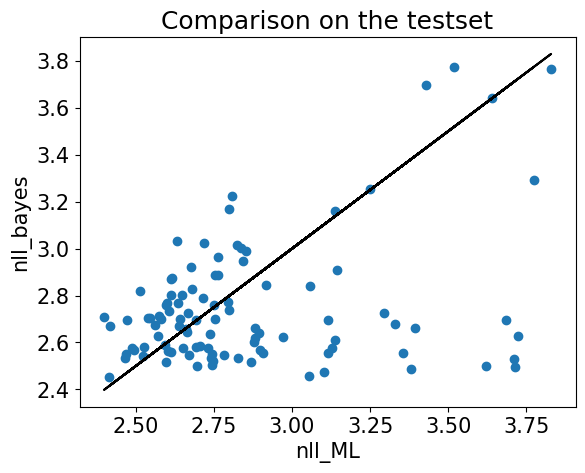

In [69]:
plt.scatter(nll_max_like, nll_bayes)
plt.plot(nll_max_like,nll_max_like,'k-') # identity line
plt.xlabel('nll_ML')
plt.ylabel('nll_bayes')
plt.title('Comparison on the testset')

2.742094258464931
2.8001895982991143


Text(0.5, 1.0, 'test NLL MaxLike')

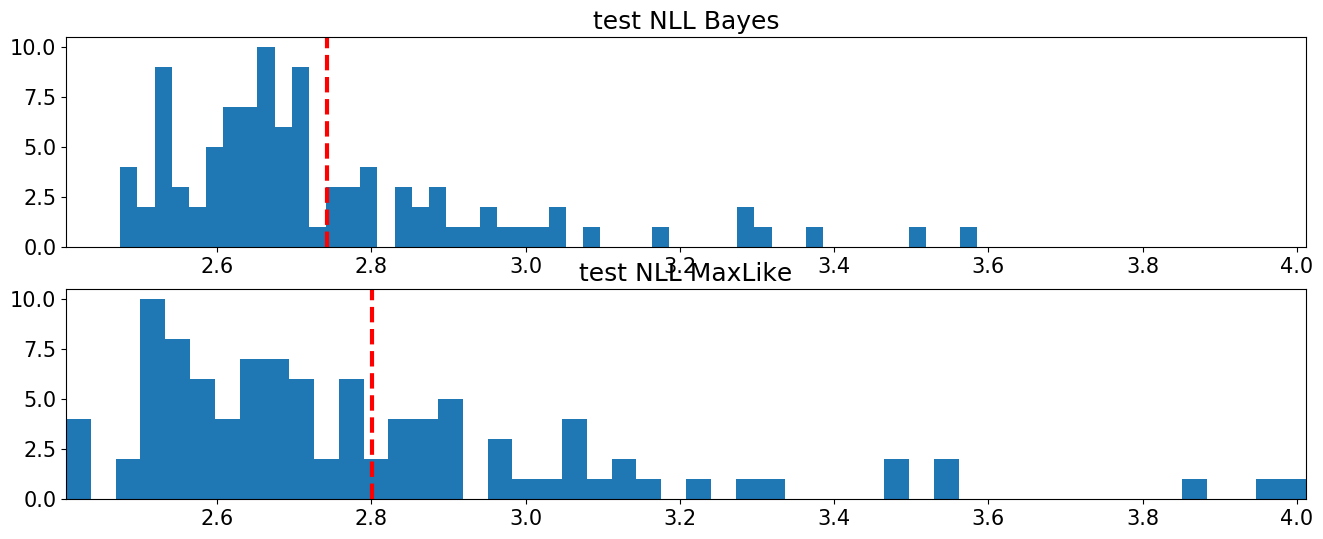

In [17]:
mean_bayes= np.mean(nll_bayes)
print(mean_bayes)
mean_ml = np.mean(nll_max_like)
print(mean_ml)

plt.figure(figsize=(16,6))
plt.subplot(2,1,1)
x_min = np.min((nll_bayes, nll_max_like))
x_max = np.max((nll_max_like, nll_max_like))

plt.hist(nll_bayes,50)
plt.xlim(x_min,x_max)
plt.axvline(mean_bayes, color='r', linestyle='dashed', linewidth=3)
plt.title('test NLL Bayes')

plt.subplot(2,1,2)
plt.hist(nll_max_like,50)
plt.xlim(x_min,x_max)
plt.axvline(mean_ml, color='r', linestyle='dashed', linewidth=3)
plt.title('test NLL MaxLike')

### Several runs different number of training points

In [19]:
N_test = 100
runs = 100
N_trains = (2,3,4,10,20,100)
maxlike = np.zeros((len(N_trains),3))
bayes = np.zeros((len(N_trains),3))

for n,N_train in enumerate(N_trains):
    print(N_train, ' ', N_test)
    nll_bayes = np.zeros(runs)
    nll_max_like = np.zeros(runs)
    for i in range(runs):
        x_train, y_train, x_test, y_test = get_data(N_train, N_test, sigma)
        m,_,_= get_nll_lin(x_train, y_train, x_test, y_test)
        nll_max_like[i] = m
        
        b ,_,_ = get_nll_bayes(x_train, y_train, x_test, y_test)
        nll_bayes[i] = b
    maxlike[n,0] = np.mean(nll_max_like)
    maxlike[n,1] = np.std(nll_max_like)
    maxlike[n,2] = np.median(nll_max_like)
    bayes[n,0]= np.mean(nll_bayes)
    bayes[n,1]= np.std(nll_bayes)
    bayes[n,2]= np.median(nll_bayes)

2   100
3   100
4   100
10   100
20   100
100   100


Text(0, 0.5, 'Average NLL (per test point)')

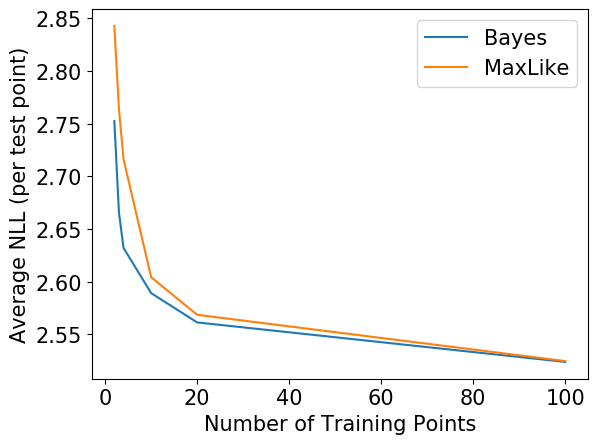

In [21]:
#plt.plot(range(len(N_trains)), bayes[:,0])
#plt.plot(range(len(N_trains)), maxlike[:,0])
plt.plot(N_trains, bayes[:,0])
plt.plot(N_trains, maxlike[:,0])

plt.legend(['Bayes','MaxLike'])
plt.xlabel('Number of Training Points')
plt.ylabel('Average NLL (per test point)')

Text(0, 0.5, 'Std NLL (per test point)')

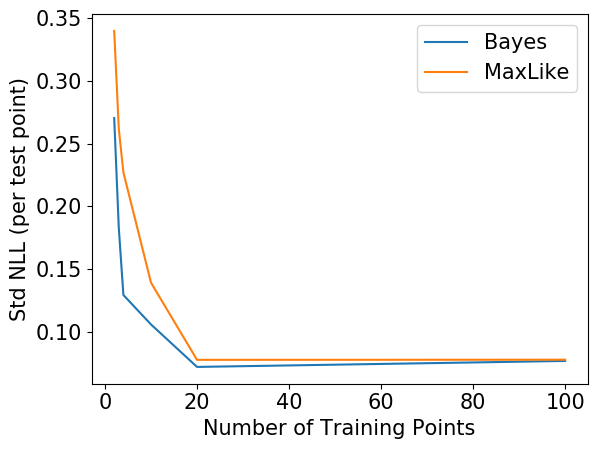

In [22]:
plt.plot(N_trains, bayes[:,1])
plt.plot(N_trains, maxlike[:,1])

plt.legend(['Bayes','MaxLike'])
plt.xlabel('Number of Training Points')
plt.ylabel('Std NLL (per test point)')